# Dynamic optimization of human walking speeds

## Optimization of energy and time predicts dynamic speeds for human walking (Carlisle and Kuo 2022)

Take walks of varying distances, and show how the optimal trajectory has
an inverted-U velocity profile, with peak speed that increases with
distance up to about 12 steps, leveling off thereafter. The cost
function is net mechanical work, plus a linear cost of time with
coefficient ctime.

### Go for a single walk

Take a walk of 10 steps, starting and ending at rest. Find the optimal
push-offs that minimize total work. The optimization is performed with
`optwalktime` which uses a time cost (relative to work) of `tchange`.

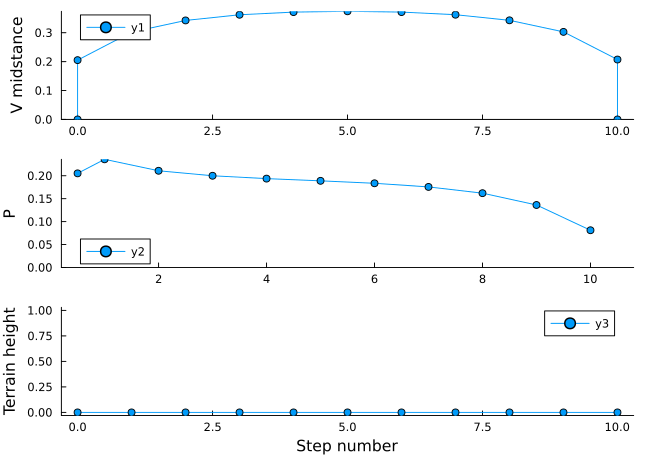

In [1]:
using DynLoco, Plots, Statistics

wstar4 = findgait(WalkRW2l(α=0.35,safety=true), target=:speed=>0.3, varying=:P)
ctime = 0.015 # cost of time, to encourage hurrying
tchange = 1.75 # boundary condition time to get up to speed (arbitrary, excluded from optimization) 
p = plot() 
nsteps = 10
result = optwalktime(wstar4, nsteps, ctime=ctime) # optimize work and time
multistepplot(result) # plot speed, push-off, terrain trajectories

All quantities are plotted dimensionlessly, with base units of body mass
$M$, leg length $L$, and gravitational acceleration $g$. Thus speed is
normalized by $\sqrt(gL)$ and time by $\sqrt(L/g)$. For a typical leg
length of $L = 1 \mathrm{m}$, the dimensional speed is about 1.25 m/s,
and step time about 0.55 s.

### Go for walks of verying distance

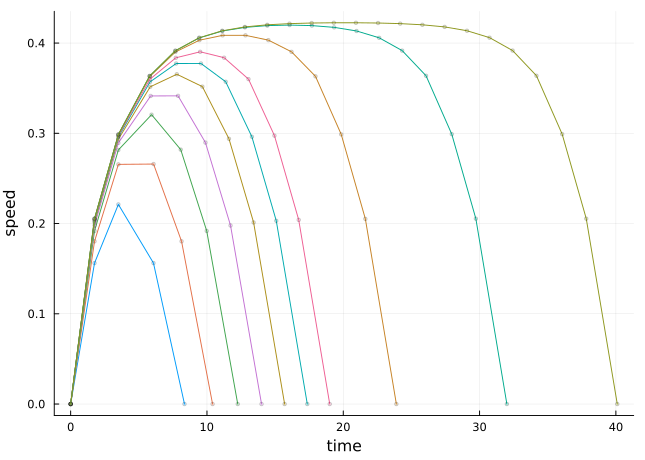

In [2]:
p = plot() 
walksteps = [1, 2, 3, 4, 5, 6, 7, 10, 15, 20] # take walks of this # of steps
results = Array{MultiStepResults,1}(undef,0) # store each optimization result here
for (i,nsteps) in enumerate(walksteps)
    result = optwalktime(wstar4, nsteps, ctime=ctime) # optimize with a cost of time
    plotvees!(p, result, tchange=tchange, usespline=false, color=i, speedtype=:shortwalks, rampuporder=1, markersize=2) # plot instantaneous body speed vs. time
    push!(results, result) # add this optimization to results array
end
Plots.display(p) # instantaneous speed vs. distance profiles

Here the speeds are plotted as “body speed” each step, to match IMU.
Model is parameterized by mid-stance speed each step, but IMU data only
yields strides. As described by Carlisle and Kuo (2022), we use
estimated mid-stance times to estimate body speed.

## Compare three objectives: Energy-Time, min-COT, constant acceleration

Walk a fixed number of steps, starting and ending at rest. The
objectives are:

-   **Energy-Time** minimizes total energy (positive work) plus
    proportional time cost
-   **min-COT** walks at a constant speed that minimizes cost of
    transport (energy per weight and distance traveled), with a
    trapezoidal speed profile. This is achieved by minimizing deviation
    from minCOT speed, to allow model to accelerate to that speed.
-   **Constant accel** accelerates at a constant rate, to yield a
    triangular speed profile. Uses a minimum variance objective to
    produce a constant rate of velocity change.

Compare for a fixed number of steps.

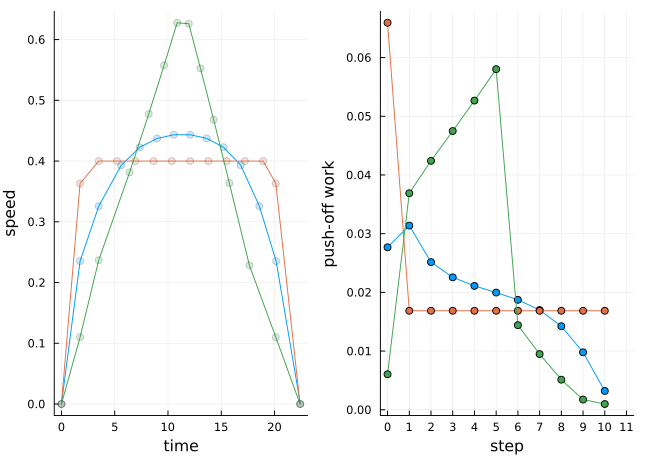

In [3]:
# A minCOT nominal gait
wstar4n = findgait(WalkRW2l(α=0.35, safety=true), target=:speed=>0.4, varying=:P) # use a speed of 0.4 to match minCOT
nsteps = 10
ctime = 0.0195
tchange = 1.75
nominalresult=optwalktime(wstar4n, nsteps, ctime = ctime, boundarywork=true) # to compare with our usual solution

# minCOT walk. optwalkvar minimizes variance from nominal
minvarresult=optwalkvar(wstar4n, nsteps, boundarywork=true)

# steady acceleration walk, which tries to maintain same
# acceleration each step, resulting in a triangular speed
# profile
A = 0.0655 # 1.9*wstar4n.vm/(nsteps*onestep(wstar4n).tf) # acceleration
v0 = 0.11 # 0.8*A*tchange # a couple acceleration constants
# chosen by hand to allow smooth transition from initiation
# to push-off.

constaccelresult = optwalktriangle(wstar4n, nsteps, A = A, boundarywork=false,boundaryvels=(v0,v0))

# Make the plots
p = plot(layout=(1,2))
plotvees!(p[1],nominalresult, tchange=tchange, rampuporder=1, usespline = false, markershape=:circle,speedtype=:shortwalks)
plotvees!(p[1],minvarresult, tchange=tchange, rampuporder=1, usespline = false,markershape=:circle, speedtype=:shortwalks)
plotvees!(p[1],constaccelresult, tchange=tchange, rampuporder=1, usespline = false,markershape=:circle, speedtype=:shortwalks, seriescolor=:auto)
plot!(p[2],[0:nsteps+1], [1/2*nominalresult.vm0^2; nominalresult.steps.Pwork; NaN],markershape=:circle,seriescolor=:auto)
plot!(p[2],[0:nsteps+1], [1/2*minvarresult.vm0^2; minvarresult.steps.Pwork; NaN],markershape=:circle,xticks=0:nsteps+1)
plot!(p[2],[0:nsteps+1], [1/2*constaccelresult.vm0^2; constaccelresult.steps.Pwork; NaN],markershape=:circle,xticks=0:nsteps+1,seriescolor=:auto)
plot!(p[2],xlabel="step", ylabel="push-off work", legend=false)
energytimework = 1/2*nominalresult.vm0^2 + sum(nominalresult.steps.Pwork)
mincotwork = 1/2*minvarresult.vm0^2 + sum(minvarresult.steps.Pwork)
trianglework = (1/2*constaccelresult.vm0^2 + sum(constaccelresult.steps.Pwork))/(1/2*nominalresult.vm0^2 + sum(nominalresult.steps.Pwork))
Plots.display(p)

Quantify the three predictions. The energy cost for each walk consists
of the positive work for gait initiation plus the positive push-off work
for all steps. Negative work is ignored, because equal magnitudes of
positive and negative work are performed for this task. If there are
constant efficiencies for muscles to perform positive and negative work,
the physiological cost of negative work is proportional to positive
work. This affects the total metabolic cost, but does not affect the
optimal solutions.

The energy-time work is 0.21077394712113307
The min-COT work is 0.23455721768541665
The const accel work is 0.2752584233181397

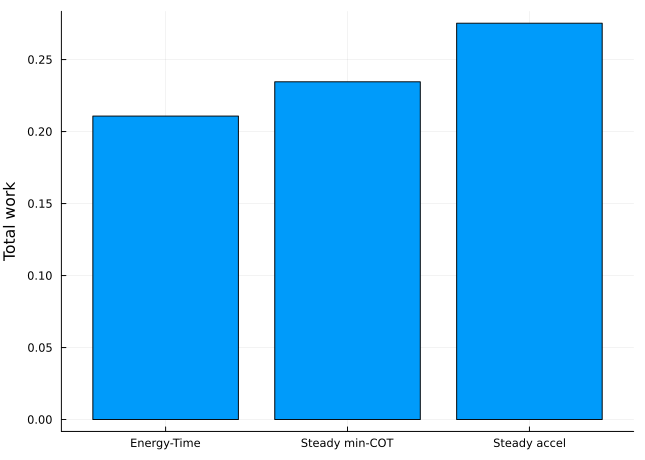

In [4]:
threecosts = [1/2*nominalresult.vm0^2 + sum(nominalresult.steps.Pwork), 1/2*minvarresult.vm0^2 + sum(minvarresult.steps.Pwork), 1/2*constaccelresult.vm0^2 + sum(constaccelresult.steps.Pwork)]
println("The energy-time work is $(threecosts[1])")
println("The min-COT work is $(threecosts[2])")
println("The const accel work is $(threecosts[3])")
bar(threecosts,xticks=((1,2,3),("Energy-Time", "Steady min-COT", "Steady accel")),legend=false,ylabel="Total work")

Minimization of cost of transport is not energetically optimal, in part
because it requires a costly fast speed-up to reach the min-COT speed.
It can be less costly to vary speed dynamically. Steady acceleration is
also costly, due to expense of accelerating at high speeds, which
requires considerable power.

## Shorter and longer step lengths do not affect waveform shapes

Longer steps are more costly because of collisions, but doesn’t change
peak speed much. For fixed number of steps, longer steps travel a
greater total distance (in greater time) and reach a slightly higher
speed. For a fixed distance, longer steps also obviously require fewer
steps. The following plot shows fixed step lengths slightly shorter or
longer than nominal.

Humans take longer steps at faster steady speeds. Applying the
approximate preferred relationship here (step length increasing with
$v^0.42$) yields similar speed profiles to fixed step lengths. The model
here modulates step length, but does not include the swing cost for
doing so. That cost is thought to be relatively higher at fast speeds
(Kuo 2001).

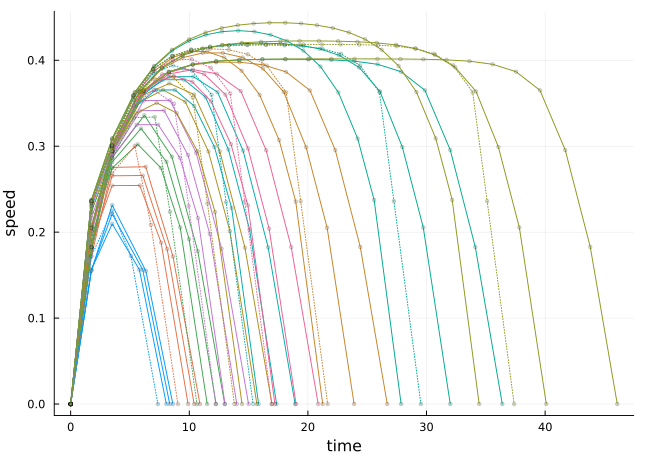

In [5]:
wstar4 = findgait(WalkRW2l(α=0.35,safety=true), target=:speed=>0.3, varying=:P)
wstar43 = findgait(WalkRW2l(α=0.3,safety=true), target=:speed=>0.3, varying=:P) # shorter steps
wstar44 = findgait(WalkRW2l(α=0.4,safety=true), target=:speed=>0.3, varying=:P) # longer steps
wsteplens = [wstar43, wstar4, wstar44]
ctime = 0.015 # cost of time, to encourage hurrying
tchange = 1.75
p = plot()
walksteps = [1, 2, 3, 4, 5, 6, 7, 10, 15, 20] # take walks of this # of steps
results43 = Array{MultiStepResults,1}(undef,0) # store each optimization result here
results = Array{MultiStepResults,1}(undef,0) # store each optimization result here
results44 = Array{MultiStepResults,1}(undef,0) # store each optimization result here
peakspds = zeros(length(walksteps))
peakspeeds43 = zeros(length(walksteps))
peakspeeds44 = zeros(length(walksteps))
durations = zeros(length(walksteps))
durations43 = zeros(length(walksteps))
durations44 = zeros(length(walksteps))
for (i,nsteps) in enumerate(walksteps)
    result = optwalktime(wsteplens[1], nsteps, ctime=ctime) # optimize with a cost of time
    plotvees!(result, tchange=tchange, usespline=false, color=i, speedtype=:shortwalks, rampuporder=1, markersize=2) # plot instantaneous speed vs. time
    push!(results43, result) # add this optimization to results array
    peakspeeds43[i] = maximum(stepspeeds(result.steps)[2])
    durations43[i] = result.totaltime
    result = optwalktime(wsteplens[2], nsteps, ctime=ctime) # optimize with a cost of time
    plotvees!(result, tchange=tchange, usespline=false, color=i, speedtype=:shortwalks, rampuporder=1, markersize=2) # plot instantaneous speed vs. time
    push!(results, result) # add this optimization to results array
    peakspds[i] = maximum(stepspeeds(result.steps)[2])
    durations[i] = result.totaltime
    result = optwalktime(wsteplens[3], nsteps, ctime=ctime)# # optimize with a cost of time
    plotvees!(result, tchange=tchange, usespline=false, color=i, speedtype=:shortwalks, rampuporder=1, markersize=2) # plot instantaneous speed vs. time
    push!(results44, result) # add this optimization to results array
    peakspeeds44[i] = maximum(stepspeeds(result.steps)[2])
    durations44[i] = result.totaltime
end # longer steps took longer and resulted in almost same peak speed but of course traveled farther
distances43 = [sum(result.steps.steplength) for result in results43]
distances = [sum(result.steps.steplength) for result in results]
distances44 = [sum(result.steps.steplength) for result in results44]

# now applying steps increasing with v^0.42 using WalkRW2lvs (linearized, varying step length)
wstar4vs = findgait(WalkRW2lvs(α=0.35,safety=true), target=:speed=>0.3, varying=:P)
ctime = 0.05 # cost of time, to encourage hurrying
tchange = 1.75
#pv = plot()
walksteps = [1, 2, 3, 4, 5, 6, 7, 10, 15, 20] # take walks of this # of steps
resultvss = Array{MultiStepResults,1}(undef,0) # store each optimization result here
tees = zeros(length(walksteps),3)
peakspeedvss = zeros(length(walksteps))
durationvss = zeros(length(walksteps))
for (i,nsteps) in enumerate(walksteps)
    result = optwalktime(wstar4vs, nsteps, ctime=ctime) # optimize with a cost of time
    plotvees!(result, tchange=tchange, usespline=false, speedtype=:shortwalks, color=i, rampuporder=1, markersize=2, linestyle=:dot) # plot instantaneous speed vs. time
    push!(resultvss, result)
    peakspeedvss[i] = maximum(stepspeeds(result.steps)[2])
    durationvss[i] = result.totaltime
     # add this optimization to results array
end
distancevss = [sum(result.steps.steplength) for result in resultvss] 

Plots.display(p) # instantaneous speed vs. distance profiles

## The valuation of time affects peak speed, but preserves self-similarity of speed profiles

Here we vary the valuation of time $c_T$ by an order of magnitude, and
find that it causes peak speeds to approximately double. The main plot
below shows variations in $c_T$ and in step length all scaled to
resemble each other and superimposed. The scaling is used to demonstrate
self-similarity of speed profiles regardless of step length and $c_T$.
The insets show variation in step length in unscaled form (horizontal
insets, also shown above), and variation in $c_T$ in unscaled form
(vertical insets).

Walks are shown for between 1 and 20 steps, for three fixed step lengths
(plus varying step length according to human preference), for six
different valuations of time ($c_T$ ranging 0.006 to 0.06). All units
are dimensionless, using body mass $M$, leg length $L$, and
gravitational acceleration $g$ as base units. For a person of typical
leg length $L = 1\,\textrm{m}$, the nominal speed is equivalent to 1.25
m/s.

Durations of a factor of 1.931255229426271
Peak speeds over a range of 2.102877847668059
  about 0.9904474300431949 to 2.0827899599175943m/s

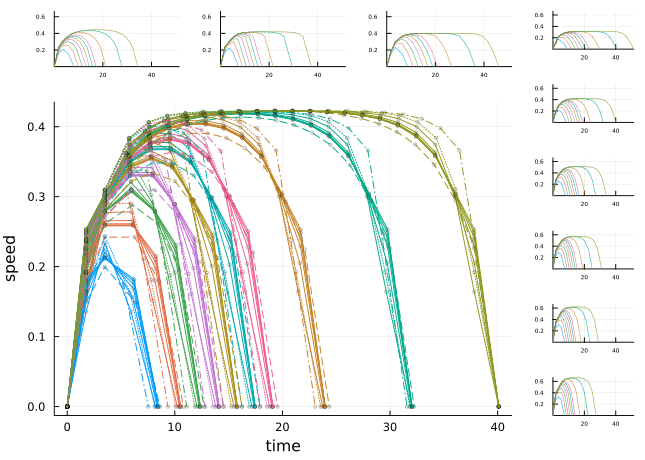

In [6]:
wstar4 = findgait(WalkRW2l(α=0.35), target=:speed=>0.3, varying=:P)
ctimes = (0.006, 0.015, 0.0276, 0.0384, 0.0492, 0.06) # valuation of time over a large range
tchange = 1.75
walksteps = [1, 2, 3, 4, 5, 6, 7, 10, 15, 20] # take walks of this # of steps
peaks = zeros(length(walksteps),length(ctimes))
durations = similar(peaks)
results = Array{MultiStepResults,2}(undef,(length(walksteps),length(ctimes))) # store each optimization result here
for (j,ctime) in enumerate(ctimes)
    for (i,nsteps) in enumerate(walksteps)
        result = optwalktime(wstar4, nsteps, ctime=ctime) # optimize with a cost of time
        peaks[i,j] = maximum(stepspeeds(result.steps)[2])
        durations[i,j] = result.totaltime
        results[i,j] = result
    end
end
tbase = durations[end,2]
vbase = peaks[end,2]
pleft = plot(; )#@layout [grid(1,3); a{0.86h}])
pright = plot(; layout=grid(6,1))
ptop = plot(; layout=grid(1,3))
for (j, ctime) in enumerate(ctimes)
    for (i,nsteps) in enumerate(walksteps)
        result = results[i,j]
        plotvees!(pright,result, tchange=tchange, color=i, usespline=:false, speedtype=:shortwalks,markersize=0, subplot=j,
            xticks = [20,40], yticks=[0.2,0.4,0.6],xguide="",yguide="",tickfontsize=4,
            xlims=(0,maximum(durations)+3tchange), ylims=(0,maximum(peaks)), linewidth=0.5) # subplot instantaneous speed vs. time
        plotvees!(pleft,result, tchange=tchange, color=i, usespline=:false, speedtype=:shortwalks,markersize=2, tscale = tbase/(durations[end,j]), 
            vscale = vbase/peaks[end,j],subplot=1) # main scaled speed vs time
    end
end
for (i,result) in enumerate(resultvss) # add in the variable step length results computed above in resultvss (dash-dot lines)
    plotvees!(pleft,result, tchange=tchange, usespline=false, speedtype=:shortwalks, color=i, markersize=2, linestyle=:dashdot,subplot=1,
    tscale = tbase/(durationvss[end]),vscale = vbase/peakspeedvss[end]) # plot instantaneous speed vs. time
    plotvees!(ptop,result, tchange=tchange, color=i, usespline=:false, speedtype=:shortwalks,markersize=0, 
        xticks = [20,40], yticks=[0.2,0.4,0.6],subplot=2,xguide="",yguide="",tickfontsize=4,
        xlims=(0,maximum(durations)+3tchange), ylims=(0,maximum(peaks)), linewidth=0.5)
end
for (i,result) in enumerate(results43) # add in shorter steps (dashed lines)
    plotvees!(pleft,result, tchange=tchange, color=i, usespline=:false, speedtype=:shortwalks,markersize=2, tscale = tbase/(durations43[end]), 
        vscale = vbase/peakspeeds43[end],subplot=1, linestyle=:dash)
    plotvees!(ptop,result, tchange=tchange, color=i, usespline=:false, speedtype=:shortwalks,markersize=0, 
        xticks = [20,40], yticks=[0.2,0.4,0.6],subplot=1,xguide="",yguide="",tickfontsize=4,
        xlims=(0,maximum(durations)+3tchange), ylims=(0,maximum(peaks)), linewidth=0.5)
end
for (i,result) in enumerate(results44) # add in longer steps (dotted lines)
    plotvees!(pleft,result, tchange=tchange, color=i, usespline=:false, speedtype=:shortwalks,markersize=2, tscale = tbase/(durations44[end]), 
        vscale = vbase/peakspeeds44[end],subplot=1, linestyle=:dot)
    plotvees!(ptop,result, tchange=tchange, color=i, usespline=:false, speedtype=:shortwalks,markersize=0,  
        xticks = [20,40], yticks=[0.2,0.4,0.6],subplot=3, xguide="",yguide="",tickfontsize=4,
        xlims=(0,maximum(durations)+3tchange), ylims=(0,maximum(peaks)), linewidth=0.5)
end
println("Durations of a factor of ", (durations[end,1]+2tchange)/(durations[end,end]+2tchange))
println("Peak speeds over a range of ", peaks[end,end]/peaks[end,1])
println("  about ", peaks[end,1]*sqrt(9.81)," to ", peaks[end,end]*sqrt(9.81), "m/s")
peaks[end,:]*sqrt(9.81)
plot(ptop, pleft, pright, layout= @layout [ [a{0.15h}; b] c{0.15w}])

## Peak speeds and durations increase with distance

Peak speeds increase toward a saturating value with increasing distance.
This relationship is self-similar, in that even with different fixed or
varying step lengths, the saturating behavior is similar.

The time duration to walk a distance also increases with distance,
approaching a straight asymptote with longer distances. The prediction
is more curved for shorter distances.

The following plot shows how peak speeds increase with distance. Greater
$c_T$ shifts the peak speed upward. The thin lines show the absolute
durations, and the thick lines show the durations after scaling them to
demonstrate self-similarity. (The results here also include different
step lengths.)

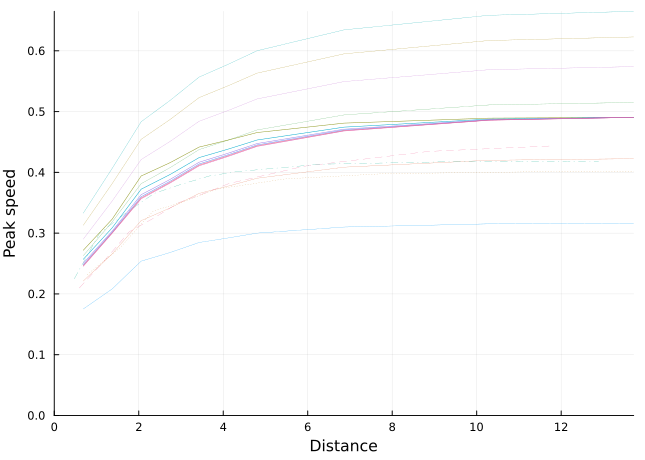

In [7]:
distances = [sum(result.steps.steplength) for result in results]
p1=plot(distances, peaks, xlabel="Distance", ylabel="Peak speed", xlims=(0,maximum(distances)), ylims=(0,Inf),legend=false, linewidth=0.2)
plot!(p1, distances43, peakspeeds43, linestyle=:dash, linewidth=0.2)
plot!(p1, distances44, peakspeeds44, linestyle=:dot, linewidth=0.2)
plot!(p1, distancevss, peakspeedvss, linestyle=:dashdot, linewidth=0.2)
plot!(p1, distances, (peaks .* middle(peaks[end,:]) ./ maximum(peaks,dims=1)), linewidth=0.5)

The following shows how walking durations increase with distance.
Greater $c_T$ results in shorter durations, but the relationship is
self-similar. The thin lines show the absolute durations, and the thick
lines show the durations after scaling them to demonstrate
self-similarity.

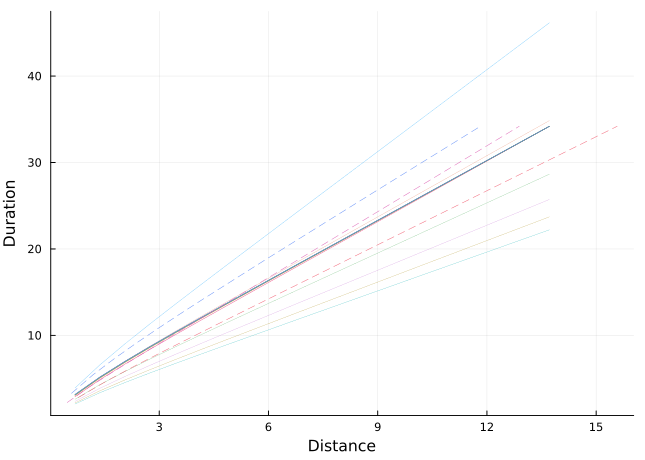

In [8]:
p1=plot(distances, durations, xlabel="Distance", ylabel="Duration",legend=false,linewidth=0.2)
plot!(distances, durations .* middle(durations[end,:])./ maximum(durations,dims=1), linewidth=0.5,xlabel="Distance", ylabel="Duration",legend=false)
plot!(distances43, durations43 .* middle(durations[end,:])./ maximum(durations43,dims=1), linewidth=0.5,xlabel="Distance", ylabel="Duration",legend=false,linestyle=:dash)
plot!(distances44, durations44 .* middle(durations[end,:])./ maximum(durations44,dims=1), linewidth=0.5,xlabel="Distance", ylabel="Duration",legend=false,linestyle=:dash)
plot!(distancevss, durationvss .* middle(durations[end,:])./ maximum(durationvss,dims=1), linewidth=0.5,xlabel="Distance", ylabel="Duration",legend=false,linestyle=:dash)

## Valuation of time affects peak speed

The following plot shows peak speed vs valuation of time $c_T$. The thin
lines show the absolute speeds, and the thick lines show the speeds
after scaling them to demonstrate self-similarity. Also included here
are walks of various distances, where longer walks have a peak speed
that is nearly steady, and shorter walks have only brief peaks.
Nevertheless, peak speed increases with $c_T$, with a roughly cube root
relationship.

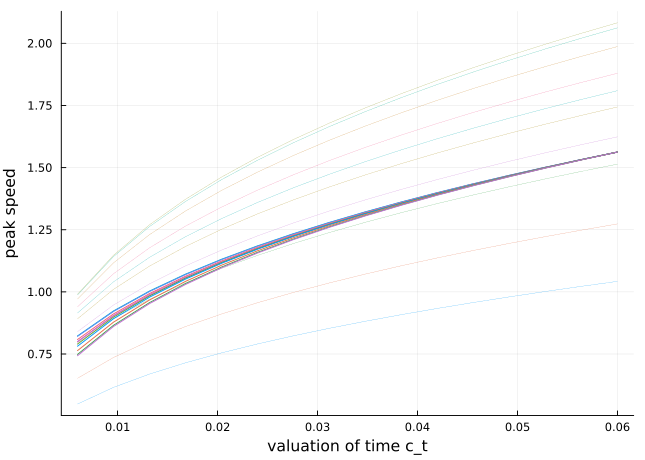

In [9]:
## Vary ct and # steps, with finer increments than before
morectimes = range(ctimes[begin], ctimes[end], length=16)
walksteps = [1,2,3,4,5,6, 7, 10, 15, 20] # take walks of this # of steps

cresults = [optwalktime(wstar4, nsteps, ctime=ctime) for nsteps in walksteps, ctime in morectimes]
cpeaks = [maximum(stepspeeds(r.steps)[2]) for r in cresults]
cdurations = [r.totaltime for r in cresults]
sec = sqrt(1/9.81); mps = sqrt(9.81)
p1=plot(morectimes, mps.*cpeaks',legend=false,xlabel="c_t",ylabel="peak speed",linewidth=0.2)
plot!(p1,morectimes, mps.*(cpeaks .* middle(cpeaks[:,end])./ maximum(cpeaks,dims=2))',linewidth=1,legend=false, xlabel="valuation of time c_t",ylabel="peak speed")

# Julia code

This page is viewable as [Jupyter notebook](shortwalks.ipynb), [plain
Julia](shortwalks.jl) text, or [HTML](shortwalks.html).

## References

Carlisle, R. Elizabeth, and Arthur D. Kuo. 2022. “Optimization of Energy
and Time Predicts Dynamic Speeds for Human Walking.” bioRxiv.
<https://doi.org/10.1101/2022.07.15.500158>.

Kuo, Arthur D. 2001. “[A Simple Model of Bipedal Walking Predicts the
Preferred Speed-Step Length
Relationship](https://www.ncbi.nlm.nih.gov/pubmed/11476370).” *Journal
of Biomechanical Engineering* 123 (3): 264–69.